稀疏化比例 epsilon = 0.1

RAW_SCORE 这个文件中 对于每个mu值（可以看作第零个坐标）

第一个坐标是样本编号

第二个坐标 0 代表稀疏化的网络 1 代表原网络

第三个坐标是方法 ['Euclidean NMI', 'Spherical NMI', 'Euclidean ECS', 'Spherical ECS']

RAW_QF 这个文件中，对于每个mu值（可以看作第零个坐标）

第一个坐标是样本编号

第二个坐标 0 代表稀疏化的网络 1 代表原网络

In [1]:
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generate an LFR Network and Draw it
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph


n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1  # Power-law exponent for the community size distribution
#mu = 0.1  # Mixing parameter
avg_deg = 25  # Average Degree
max_deg = int(0.1 * n)  # Max Degree
min_commu = 60  # Min Community Size
max_commu = int(0.1 * n)  # Max Community Size

#for mu in np.arange(0.1, 0.11, 0.1):

In [1]:
import sys
import os

# 将子目录添加到 sys.path
current_dir = os.getcwd()
sys.path.append(os.path.join(os.path.join(current_dir),'EffectiveResistanceSampling'))

from EffectiveResistanceSampling.Network import *
import numpy as np
    
import networkx as nx
import scipy.sparse

def to_networkx(self):
    if isinstance(self.graph, scipy.sparse.csr.csr_matrix):
        return nx.from_scipy_sparse_matrix(self.graph)
    else:
        return nx.from_numpy_array(self.graph)

In [4]:
#%%time
# This function takes the orthogonal part of G_sparse eigenvectors.
# Hopefully, we will get a better community detection result from this treatment.
import networkx as nx
import numpy as np

def compute_orthogonal_components(G, V):
    """
    Compute the component of each column of V orthogonal to the degree sequence vector of a graph.

    Parameters:
    G (networkx.classes.graph.Graph): The input graph.
    V (numpy.ndarray): The input 2D array.

    Returns:
    numpy.ndarray: The component of each column of V orthogonal to the degree sequence vector of the graph.
    """
    # get measure and constant vector
    mu = np.array([d for n, d in G.degree()])
    u = np.ones(G.number_of_nodes())

    # 
    orthogonal_components = np.zeros_like(V)

    # do orthogonal for each column
    for i in range(V.shape[1]):
        v = V[:, i]
        orthogonal_component = v - ((v @ (u * mu)) / (u @ (u * mu))) * u
        orthogonal_components[:, i] = orthogonal_component  # 

    return orthogonal_components

In [5]:
# This is the function for Laplacian Eigenmap using Cupy. The presence of GPU is required.

import numpy as np
import networkx as nx
import cupy as cp

def lap_cupy(graph, dim):
    """
    Compute the Laplacian embedding of a graph using CuPy.

    Parameters:
    graph (networkx.classes.graph.Graph): The input graph.
    dim (int): The dimension of the embedding.

    Returns:
    numpy.ndarray: The Laplacian embedding of the graph.
    """
    # Check inputs
    assert isinstance(graph, nx.Graph), "Input graph must be a NetworkX graph."
    assert isinstance(dim, int) and dim > 0, "Input dim must be a positive integer."
    assert dim < graph.number_of_nodes(), "Input dim must be less than the number of nodes in the graph."

    # Convert the adjacency matrix of the graph to a CuPy array
    A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)

    # Compute L1 normalization along axis 1 (rows)
    row_sums = cp.linalg.norm(A, ord=1, axis=1)
    P = A / row_sums.reshape(-1, 1)

    # Compute the eigenvalues and eigenvectors of I_n - P
    I_n = cp.eye(graph.number_of_nodes())
    w, v = cp.linalg.eigh(I_n - P) # v 的每列是一个特征向量

    # Sort the eigenvectors by the real part of the eigenvalues
    v = v[:, cp.argsort(w.real)]
    
    v_return = v[:, 1:(dim+1)].get().real

    # Return the embedding
    return v_return  # Explicitly convert to NumPy array using .get()

In [6]:
### KMeans Clustering using Euclidean and Spherical metrics
### Using NMI and ECSim for comparison
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import clusim.sim as sim
from clusim.clustering import Clustering


def euclid_membership(K, points):
    euc_kmeans = KMeans(n_clusters=K, n_init=10)
    euc_kmeans.fit(points)

    evala_euclid_membership = euc_kmeans.labels_
    return evala_euclid_membership

def cosine_membership(K, points):
    normalized_points = normalize(points)
    cos_kmeans = KMeans(n_clusters=K, n_init=10)
    cos_kmeans.fit(normalized_points)

    evala_cosine_membership = cos_kmeans.labels_
    return evala_cosine_membership

def calculate_score(evala, intr_list, K):
# evala is the embedding vectors
# intr_list is the intrinsic community strucuture
# K is the number of clusters in Kmeans
    return_val = [] # 首先准备好返回值 

    intr_clus = Clustering({i: [intr_list[i]] for i in range(len(intr_list))})

    evala_euclid_membership = euclid_membership(K, evala)

    evala_cosine_membership = cosine_membership(K, evala)

    ## compare with intrinsic community structure using NMI
    return_val.append(normalized_mutual_info_score(evala_euclid_membership, intr_list, average_method='arithmetic'))
    return_val.append(normalized_mutual_info_score(evala_cosine_membership, intr_list, average_method='arithmetic'))
    
    
    evala_euclid_clustering = Clustering(elm2clu_dict={i: [evala_euclid_membership[i]] for i in range(len(evala_euclid_membership))})
    evala_cosine_clustering = Clustering(elm2clu_dict={i: [evala_cosine_membership[i]] for i in range(len(evala_cosine_membership))})
    
    ## compare with intrinsic community structure using ECSim
    evala_euclid_similarity = sim.element_sim(intr_clus, evala_euclid_clustering, alpha=0.9)
    evala_cosine_similarity = sim.element_sim(intr_clus, evala_cosine_clustering, alpha=0.9)
    return_val.append(evala_euclid_similarity)
    return_val.append(evala_cosine_similarity)
    
    return return_val

In [7]:
import numpy as np

step_total  = 10
step_size = 0.05
MU = np.arange(step_size, step_size*step_total+0.01, step_size)

SAMPLE = 100

stat = np.zeros((step_total, 2, 4))
qf_ratio = np.zeros((step_total))

K = 15

RAW_SCORE={}
RAW_QF={}

In [8]:
import numpy as np
import networkx as nx
from concurrent.futures import ProcessPoolExecutor


def process_mu(mu):
    raw_score_mu = np.zeros((SAMPLE, 2, 4))
    raw_qf_mu = np.zeros((SAMPLE, 2))
    for i in range(SAMPLE):
        G = LFR_benchmark_graph(
            n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu,
            seed = 2024
        )

        G = nx.Graph(G)
        selfloop_edges = list(nx.selfloop_edges(G))
        G.remove_edges_from(selfloop_edges)

        intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
        intrinsic_membership = {}
        for node in range(G.number_of_nodes()):
            for index, inner_set in enumerate(intrinsic_communities):
                if node in inner_set:
                    intrinsic_membership[node] = index
                    break
        intrinsic_membership = list(intrinsic_membership.values())

        edge_list = list(G.edges())
        edge_list = np.array(edge_list)

        edge_weights = nx.get_edge_attributes(G, 'weight')
        edge_weights = np.array(edge_weights)

        edge_weights = [edge_weights[edge] if edge in edge_weights else 1 for edge in edge_list]

        Gn = Network(edge_list, edge_weights)

        epsilon = 0.1
        method = 'spl'
        Effective_R = Gn.effR(epsilon, method)

        q = 10000
        seed = 2024
        
        while(True):
            Gn_Sparse = Gn.spl(q, Effective_R, seed=seed)

            G_sparse = to_networkx(Gn_Sparse)
            if nx.is_connected(G_sparse):
                break           
        A = np.asarray(nx.adjacency_matrix(G, nodelist=G.nodes(), weight='weight').toarray(), dtype=np.float64)
        embedding_sparse = lap_cupy(G_sparse, K)
        embedding_original = lap_cupy(G, K)
        
        #score_sparse_orth = calculate_score(
        #    compute_orthogonal_components(G, embedding_sparse), intrinsic_membership, len(np.unique(intrinsic_membership)))
        #raw_score_mu[i, 0] = score_sparse_orth
        score_sparse = calculate_score(embedding_sparse, intrinsic_membership, len(np.unique(intrinsic_membership)))
        raw_score_mu[i, 0] = score_sparse
        
        quadratic_form_sparse = 0
        for k in range(embedding_sparse.shape[1]):
            vk = embedding_sparse[:, k]
            for s in range(A.shape[0]):
                for t in range(A.shape[1]):
                    quadr = A[s, t] * (vk[s] - vk[t]) ** 2
                    quadratic_form_sparse += quadr
        raw_qf_mu[i,0] = quadratic_form_sparse
        #print(quadratic_form_sparse)
        
        
        score_original = calculate_score(embedding_original, intrinsic_membership, len(np.unique(intrinsic_membership)))
        raw_score_mu[i, 1] = score_original

        quadratic_form_original = 0
        for k in range(embedding_original.shape[1]):
            vk = embedding_original[:, k]
            for s in range(A.shape[0]):
                for t in range(A.shape[1]):
                    #print(A[s, t])
                    quadr = A[s, t] * (vk[s] - vk[t]) ** 2
                    quadratic_form_original += quadr
        #print(quadratic_form_original)
            
        raw_qf_mu[i,1] = quadratic_form_original
        
        print(i)

    return mu, raw_score_mu, np.mean(raw_score_mu, axis=0), raw_qf_mu

In [9]:
with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_mu, MU))

0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
15
14
15
15
15
15
15
15
15
15
16
16
16
15
16
16
16
16
16
16
17
17
17
17
16
17
17
17
17
17
18
18
18
18
18
18
17
18
18
19
19
18
19
19
19
19
18
19
19
20
20
20
19
20
20
20
19
20
20
21
21
21
20
21
21
21
21
20
21
22
22
22
22
22
22
21
22
21
22
23
23
23
23
23
23
22
23
22
23
24
24
24
24
24
24
23
24
23
24
25
25
25
25
25
25
25
24
24
25
26
26
26
26
26
26
26
25
25
26
27
27
27
27
27
27
27
26
26
28
28
27
28
28
28
28
28
27
27
29
29
29
28
29
29
29
29
28
28
30
30
30
29
30
30
30
30
29
29
31
31
31
31
30
31
31
31
30
30
32
32
32
32
31
32
32
32
33
31
31
33
33
33
32
33
33
33
34
34
32
32
34
34
34
33
34
34
35
35
33
35
33
35
35
34
35
35
36
36
36
34
36
34
36
35
36
36
37
37

In [10]:
for mu, raw_score_mu, mean_score, raw_qf_mu in results:
    RAW_SCORE[mu] = raw_score_mu
    RAW_QF[mu] = raw_qf_mu
    stat[int(mu / step_size + 0.001) - 1] = mean_score
    
    ratios = raw_qf_mu[:, 0] / raw_qf_mu[:, 1]
    qf_ratio[[int(mu / step_size + 0.001) - 1]] = np.mean(ratios)

print("并行计算完成")

并行计算完成


In [11]:
import pickle

# 将 RAW_SCORE 存储到文件
with open('data/lfr_lap_raw_score.pkl', 'wb') as file:
    pickle.dump(RAW_SCORE, file)

print("RAW_SCORE 已成功存储到 lfr_lap_raw_score.pkl 文件中")

# 将 RAW_QF 存储到文件
with open('data/lfr_lap_raw_qf.pkl', 'wb') as file:
    pickle.dump(RAW_QF, file)

print("RAW_QF 已成功存储到 lfr_lap_raw_score.pkl 文件中")

RAW_SCORE 已成功存储到 raw_score.pkl 文件中
RAW_QF 已成功存储到 raw_score.pkl 文件中


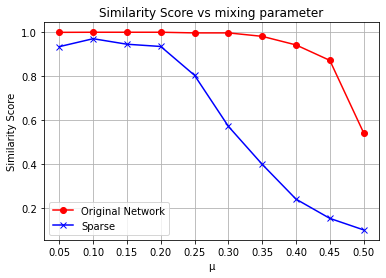

In [12]:
import numpy as np
import matplotlib.pyplot as plt

method = 2


# 绘制每列的折线图
plt.plot(stat[:, 1, method], label='Original Network', color='r', marker='o')  # 红色曲线
plt.plot(stat[:, 0, method], label='Sparse', color='b', marker='x')  # 蓝色曲线

# 添加网格
plt.grid(True)

# 添加图例并设置位置
plt.legend(loc='best')

# 添加标签和标题
x_labels = np.arange(0.05, 0.55, 0.05)
plt.xticks(ticks=np.arange(len(x_labels)), labels=[f'{x:.2f}' for x in x_labels])
plt.xlabel('μ')
plt.ylabel('Similarity Score')
plt.title('Similarity Score vs mixing parameter')

# 显示图形
plt.show()

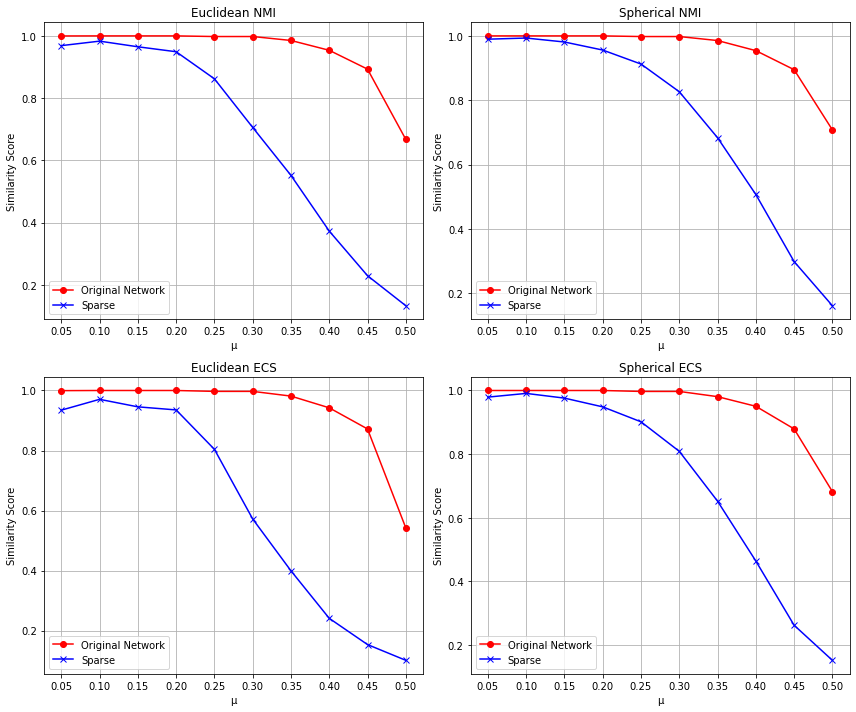

In [13]:
import numpy as np
import matplotlib.pyplot as plt


methods = [0, 1, 2, 3]
titles = ['Euclidean NMI', 'Spherical NMI', 'Euclidean ECS', 'Spherical ECS']

# 创建 2x2 网格布局
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 绘制每个 method 的折线图
for i, method in enumerate(methods):
    ax = axs[i // 2, i % 2]
    ax.plot(stat[:, 1, method], label='Original Network', color='r', marker='o')  # 红色曲线
    ax.plot(stat[:, 0, method], label='Sparse', color='b', marker='x')  # 蓝色曲线
    
    # 添加网格
    ax.grid(True)
    
    # 添加图例并设置位置
    ax.legend(loc='best')
    
    # 添加标签和标题
    x_labels = np.arange(0.05, 0.55, 0.05)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels([f'{x:.2f}' for x in x_labels])
    ax.set_xlabel('μ')
    ax.set_ylabel('Similarity Score')
    ax.set_title(titles[i])

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()